# [Where's Waldo?](https://www.wikihow.com/Find-Waldo)

## Fingerprinting
Browser fingerprinting is a technique used to identify and track individuals based on unique characteristics of their web browser configuration. These characteristics can include the browser type, version, installed plugins, and screen resolution, among others. By combining these attributes, websites can create a digital fingerprint that can be used to track user behavior across multiple sites, even if they clear their cookies or use different devices. This has raised concerns about privacy and the potential for this technology to be used for targeted advertising, surveillance, and other purposes.

[Read more]([Fingerprinting](https://datadome.co/learning-center/browser-fingerprinting-techniques/))

##  Task
To build a fully connect feed-forward ANN model for a classification problem.

To do data preprocessing, data analysis, design the ANN model, then fine-tune your model architecture.

Do $ 80/20 $ train/test split for evaluating model.

### Data
Data in `Waldo.csv` for identifying waldo (the user with `user_id=0`) 

The columns include:
 - browser
 - os
 - locale
 - user_id
 - gender
 - location
 - sites
 - time
 - date

Verification of model by predicting each user in `Waldo_verify.csv` whether it's Waldo or not. Output:

`row_idx: is_waldo`, if the user is Waldo output should be 1

``` 
0: 1
1: 0
2: 0
3: 1
4: 1
...
```



## Solution

During the solution of this task I checked the necessity of saving "sites" in dataset.

In order to code the sites, I extracted a second level domain (SLD) from each of them and used them as additional features, also I used the "length" parameter as the value for these features. All other features were encoded with binary encoder and their total number was **5537**.

After building the ANN model, fit and prediction I got the following metrics:
* *Testing accuracy* = 0.9629992648860574
* *Testing precision* = 0.9235066233441639
* *Testing recall* = 0.9385786802030457
* *Testing F1-score* = 0.9309816537899129
* *Mean Absolute Error* = 0.03700073511394266
* *Mean Squared Error* = 0.03700073511394266
* *Root Mean Squared Error* = 0.19235575144492734
* *R2 score* = -0.1092468589891204944

In the other model, I dropped the sites and encoded the rest of the features with a binary encoder. Total number of them was **17**.

After building the ANN model, fit and prediction I got the following metrics:
* *Testing accuracy* = 0.9990198480764518
* *Testing precision* = 1.0
* *Testing recall* = 0.9523809523809523
* *Testing F1-score* = 0.975609756097561
* *Mean Absolute Error* = 0.00098015192354815
* *Mean Squared Error* = 0.00098015192354815
* *Root Mean Squared Error* = 0.03130737810082713
* *R2 score* = 0.9513802018180302

Based on the metrics and model building process I've concluded that it is better to drop "sites" to simplify the model building process, its training, and to get better results.

In [ ]:
# !pip install category_encoders
# !pip install keras_tuner
# !pip install timezonefinder

In [ ]:
import math
import pytz
import warnings
import numpy as np
import pandas as pd
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from datetime import datetime, timedelta
from category_encoders import BinaryEncoder
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import BayesianOptimization
from keras_tuner import Objective
from geopy.geocoders import Nominatim
from timezonefinder import TimezoneFinder
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

## Data pre-processing

In [ ]:
df = pd.read_csv("Waldo.csv")
df

,index,browser,os,locale,user_id,location,sites,time,date
0,8909,Firefox,Windows 10,zh-CN,46,China/Shanghai,"[{'site': '1.static.dpreview.com', 'length': 1...",14:14:00,2016-01-28
1,17679,Internet Explorer,Windows 8,ro-RO,21,Germany/Berlin,"[{'site': 'safebrowsing-cache.google.com', 'le...",05:23:00,2016-08-26
2,11803,Internet Explorer,MacOS,ur-PK,98,Australia/Sydney,"[{'site': 'www.ncbi.nlm.nih.gov', 'length': 10...",12:03:00,2016-03-13
3,356,Internet Explorer,Ubuntu,pl-PL,44,Japan/Tokyo,"[{'site': 'fr.hdscreen.me', 'length': 16}, {'s...",06:08:00,2017-01-19
4,10948,Internet Explorer,Windows 8,bg-BG,59,Japan/Tokyo,"[{'site': '193.164.196.50', 'length': 10}, {'s...",03:59:00,2017-05-13
...,...,...,...,...,...,...,...,...,...
20396,9076,Safari,Windows 10,es-MX,55,Japan/Tokyo,"[{'site': 's.youtube.com', 'length': 168}, {'s...",05:02:00,2016-08-02
20397,11021,Chrome,Debian,en-US,37,UK/London,"[{'site': 'ajax.googleapis.com', 'length': 122...",22:20:00,2017-01-14
20398,11616,Chrome,Windows 10,ro-RO,175,USA/Chicago,"[{'site': 'blast.ncbi.nlm.nih.gov', 'length': ...",04:06:00,2016-11-05
20399,1863,Firefox,Ubuntu,vi-VN,142,China/Shanghai,"[{'site': 'www.google.fr', 'length': 9}, {'sit...",10:31:00,2016-08-01


During the solution of the task, I made an assumption that the time that is given in the table corresponds to the local time of each user. Therefore, to compensate this difference, I decided to subtract the time zone offset corresponding to the location of the user. It was assumed that the user was actually at the place specified in the "location" and not using a VPN.

In [ ]:
# To convert time
geolocator = Nominatim(user_agent="Ketch")
time_finder = TimezoneFinder()

In [ ]:
def date_time_transformer(df):
    """
    Transform date and time of the dataframe

    :param df: Pandas dataframe
    :return: Pandas dataframe with encoded date and time
    """
    new_df = df.copy()

    # Defining all possible locations of the users
    location_to_timezone = {}
    for location in new_df['location']:
        if location not in location_to_timezone.keys():
            # Identifing coordintes by location
            coords = geolocator.geocode(location)
            timezone = time_finder.timezone_at(lng=coords.longitude, lat=coords.latitude)
            location_to_timezone[location] = timezone

    integer = 0
    # Converting date and time to timestamp
    for time, date, location in zip(new_df['time'], 
                                    new_df['date'], 
                                    new_df['location']):
        # Calculating local time offset
        timezone = location_to_timezone[location]
        offset = datetime.now(pytz.timezone(timezone)).utcoffset()
        datetime_object = datetime.strptime(str(date) + " " + str(time), '%Y-%m-%d %H:%M:%S')
        datetime_object -= offset
        
        # Converting to timestamp
        new_df.at[integer, 'timestamp'] = datetime_object.timestamp()
        integer+=1
    return new_df

In [ ]:
# Transform date and time of the current dataset
new_df = date_time_transformer(df)
new_df

,index,browser,os,locale,user_id,location,sites,time,date,timestamp
0,8909,Firefox,Windows 10,zh-CN,46,China/Shanghai,"[{'site': '1.static.dpreview.com', 'length': 1...",14:14:00,2016-01-28,1.453962e+09
1,17679,Internet Explorer,Windows 8,ro-RO,21,Germany/Berlin,"[{'site': 'safebrowsing-cache.google.com', 'le...",05:23:00,2016-08-26,1.472182e+09
2,11803,Internet Explorer,MacOS,ur-PK,98,Australia/Sydney,"[{'site': 'www.ncbi.nlm.nih.gov', 'length': 10...",12:03:00,2016-03-13,1.457835e+09
3,356,Internet Explorer,Ubuntu,pl-PL,44,Japan/Tokyo,"[{'site': 'fr.hdscreen.me', 'length': 16}, {'s...",06:08:00,2017-01-19,1.484774e+09
4,10948,Internet Explorer,Windows 8,bg-BG,59,Japan/Tokyo,"[{'site': '193.164.196.50', 'length': 10}, {'s...",03:59:00,2017-05-13,1.494616e+09
...,...,...,...,...,...,...,...,...,...,...
20396,9076,Safari,Windows 10,es-MX,55,Japan/Tokyo,"[{'site': 's.youtube.com', 'length': 168}, {'s...",05:02:00,2016-08-02,1.470082e+09
20397,11021,Chrome,Debian,en-US,37,UK/London,"[{'site': 'ajax.googleapis.com', 'length': 122...",22:20:00,2017-01-14,1.484429e+09
20398,11616,Chrome,Windows 10,ro-RO,175,USA/Chicago,"[{'site': 'blast.ncbi.nlm.nih.gov', 'length': ...",04:06:00,2016-11-05,1.478337e+09
20399,1863,Firefox,Ubuntu,vi-VN,142,China/Shanghai,"[{'site': 'www.google.fr', 'length': 9}, {'sit...",10:31:00,2016-08-01,1.470019e+09


In [ ]:
# Dividing into featrues and labels
y = new_df['user_id']
X = new_df.drop(['sites','index','user_id', 'time', 'date'], axis=1)
X

,browser,os,locale,location,timestamp
0,Firefox,Windows 10,zh-CN,China/Shanghai,1.453962e+09
1,Internet Explorer,Windows 8,ro-RO,Germany/Berlin,1.472182e+09
2,Internet Explorer,MacOS,ur-PK,Australia/Sydney,1.457835e+09
3,Internet Explorer,Ubuntu,pl-PL,Japan/Tokyo,1.484774e+09
4,Internet Explorer,Windows 8,bg-BG,Japan/Tokyo,1.494616e+09
...,...,...,...,...,...
20396,Safari,Windows 10,es-MX,Japan/Tokyo,1.470082e+09
20397,Chrome,Debian,en-US,UK/London,1.484429e+09
20398,Chrome,Windows 10,ro-RO,USA/Chicago,1.478337e+09
20399,Firefox,Ubuntu,vi-VN,China/Shanghai,1.470019e+09


In [ ]:
# Encoding 'location', 'browser', 'os' and 'locale' by binary encoder
encoder = BinaryEncoder(cols=['location', 'browser', 'os', 'locale']).fit(X)
df_binary = encoder.transform(X)
df_binary

,browser_0,browser_1,browser_2,os_0,os_1,os_2,locale_0,locale_1,locale_2,locale_3,locale_4,location_0,location_1,location_2,location_3,location_4,timestamp
0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,1.453962e+09
1,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,1.472182e+09
2,0,1,0,0,1,1,0,0,0,1,1,0,0,0,1,1,1.457835e+09
3,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1.484774e+09
4,0,1,0,0,1,0,0,0,1,0,1,0,0,1,0,0,1.494616e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20396,1,0,0,0,0,1,1,0,1,1,0,0,0,1,0,0,1.470082e+09
20397,0,1,1,1,0,1,0,1,1,0,1,0,1,1,0,1,1.484429e+09
20398,0,1,1,0,0,1,0,0,0,1,0,0,1,0,0,1,1.478337e+09
20399,0,0,1,1,0,0,0,1,1,0,0,0,0,0,0,1,1.470019e+09


In [ ]:
# Scaling
scaler = StandardScaler().fit(df_binary)
df_encoded = pd.DataFrame(scaler.transform(df_binary), columns=df_binary.columns)
df_encoded

,browser_0,browser_1,browser_2,os_0,os_1,os_2,locale_0,locale_1,locale_2,locale_3,locale_4,location_0,location_1,location_2,location_3,location_4,timestamp
0,-0.480293,-1.017855,0.629657,-0.566388,-0.874699,0.722030,-0.726513,-0.783991,-0.972392,-0.927662,1.007034,-0.588049,-0.784399,-0.929309,-0.949837,0.924648,-1.652878
1,-0.480293,0.982459,-1.588166,-0.566388,1.143251,-1.384984,-0.726513,-0.783991,-0.972392,1.077979,-0.993015,-0.588049,-0.784399,-0.929309,1.052812,-1.081493,-0.438168
2,-0.480293,0.982459,-1.588166,-0.566388,1.143251,0.722030,-0.726513,-0.783991,-0.972392,1.077979,1.007034,-0.588049,-0.784399,-0.929309,1.052812,0.924648,-1.394674
3,-0.480293,0.982459,-1.588166,1.765575,-0.874699,-1.384984,-0.726513,-0.783991,1.028392,-0.927662,-0.993015,-0.588049,-0.784399,1.076068,-0.949837,-1.081493,0.401316
4,-0.480293,0.982459,-1.588166,-0.566388,1.143251,-1.384984,-0.726513,-0.783991,1.028392,-0.927662,1.007034,-0.588049,-0.784399,1.076068,-0.949837,-1.081493,1.057458
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20396,2.082064,-1.017855,-1.588166,-0.566388,-0.874699,0.722030,1.376437,-0.783991,1.028392,1.077979,-0.993015,-0.588049,-0.784399,1.076068,-0.949837,-1.081493,-0.578176
20397,-0.480293,0.982459,0.629657,1.765575,-0.874699,0.722030,-0.726513,1.275525,1.028392,-0.927662,1.007034,-0.588049,1.274862,1.076068,-0.949837,0.924648,0.378323
20398,-0.480293,0.982459,0.629657,-0.566388,-0.874699,0.722030,-0.726513,-0.783991,-0.972392,1.077979,-0.993015,-0.588049,1.274862,-0.929309,-0.949837,0.924648,-0.027824
20399,-0.480293,-1.017855,0.629657,1.765575,-0.874699,-1.384984,-0.726513,1.275525,1.028392,-0.927662,-0.993015,-0.588049,-0.784399,-0.929309,-0.949837,0.924648,-0.582380


In [ ]:
# Transforming labels into binary format
y_encoded = y.copy()
for i in range(len(y_encoded)):
    if y_encoded[i]!=0:
        y_encoded[i]=0
    else:
        y_encoded[i]=1
y_encoded = pd.get_dummies(y_encoded)
y_encoded

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
20396,1,0
20397,1,0
20398,1,0
20399,1,0


In [ ]:
print(df_encoded.shape)
print(y_encoded.shape)

(20401, 17)
(20401, 2)


In [ ]:
# Spliting into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(df_encoded, y_encoded, test_size=0.2, 
                                                    random_state=123, stratify=np.array(y_encoded))

X_train = np.asarray(X_train).astype(np.float32)
X_test = np.asarray(X_test).astype(np.float32)
y_train = np.asarray(y_train).astype(np.float32)
y_test = np.asarray(y_test).astype(np.float32)

## Building model

In [ ]:
def build_model(hp):
    """
    Fine-tuning the ANN model

    :param hp: hyperparameters to be tuned
    :return: tuned model
    """
    # List of possible activation functions
    activation_choice = hp.Choice('activation', values=['relu', 'sigmoid', 'tanh', 'elu', 'selu'])
    model = keras.Sequential()
    
    # Specifying at least one hidden layer
    model.add(keras.layers.Dense(units=hp.Int('units_' + str(0),
                                            min_value=4,
                                            max_value=16,
                                            step=2),
                           input_shape=(df_encoded.shape[1],),
                           activation=activation_choice))
    
    # Choice of network depth
    for i in range(hp.Int('num_layers', 0, 2)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i+1),
                                            min_value=4,
                                            max_value=16,
                                            step=2),
                               activation=activation_choice))
        
    # Specifying exactly one output layer with 2 nodes and sigmoid activation function
    model.add(keras.layers.Dense(y_encoded.shape[1], activation='sigmoid'))
    
    # Compiling of model
    adam = Adam(hp.Choice("learning_rate", [0.001, 0.00035, 0.0006]))
    model.compile(
        optimizer=adam,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
accuracy_obj = Objective("val_accuracy", direction="max")

In [ ]:
# Creating the tuner by Bayesian optimizer
tuner = BayesianOptimization(
    build_model,
    objective=[accuracy_obj],
    max_trials=20,
    directory='AB_2_3')

## Train / Val / Test

In [ ]:
# Searching for best model
history = tuner.search(X_train, y_train,
             epochs=20, batch_size=100,
             validation_split = 0.2, verbose=2)

Trial 20 Complete [00h 00m 08s]
multi_objective: -0.9877680018544197

Best multi_objective So Far: -0.9943206305615604
Total elapsed time: 00h 02m 51s
INFO:tensorflow:Oracle triggered exit


In [ ]:
# Choosing the best found model
models = tuner.get_best_models(num_models = 1)
models[0].summary()

# Evaluating on the test set
models[0].evaluate(X_test, y_test)

0
1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 14)                252       
                                                                 
 dense_1 (Dense)             (None, 16)                240       
                                                                 
 dense_2 (Dense)             (None, 14)                238       
                                                                 
 dense_3 (Dense)             (None, 2)                 30        
                                                                 
Total params: 760
Trainable params: 760
Non-trainable params: 0
_________________________________________________________________
128/128 [==============================] - 1s 1ms/step - loss: 0.0031 - mean_absolute_error: 0.0057 - accuracy: 0.9990


[0.003054492175579071, 0.005735394079238176, 0.9990198612213135]

In [ ]:
def print_metrics(y_actual, y_pred):
    """
    Evaluate the performance of a model while printing MAE, MSE, RMSE and R2 metrics

    :param y_actual: Actual targets from the test set
    :param y_pred: Values predicted by the model
    """
    print("Mean Absolute Error: ", metrics.mean_absolute_error(y_actual, y_pred))
    print("Mean Squared Error: ", metrics.mean_squared_error(y_actual, y_pred))
    print("Root Mean Squared Error: ", math.sqrt(metrics.mean_squared_error(y_actual, y_pred)))
    print("R2 score: ", metrics.r2_score(y_actual, y_pred))
    
def print_clf_metrics(y_actual, y_pred):
    """
    Evaluate the performance of a model while printing 
    Accuracy, Precision, Recall and F1 scores

    :param y_actual: Actual target from the test set
    :param y_pred: Value predicted by the model
    """
    
    print(f'Testing accuracy = {metrics.accuracy_score(y_actual, y_pred)}')
    print(f'Testing precision = {metrics.precision_score(y_actual, y_pred)}')
    print(f'Testing recall = {metrics.recall_score(y_actual, y_pred)}')
    print(f'Testing F1-score = {metrics.f1_score(y_actual, y_pred)}')

In [ ]:
# Predicting values for test set
y_pred = models[0].predict(X_test)
y_predicted = []
y_actual = []
for i, j in zip(y_pred, y_test):
    y_predicted.append(np.argmax(i))
    y_actual.append(np.argmax(j))
    
# Calculating metrics with custom functions
print_clf_metrics(y_predicted, y_actual)
print_metrics(y_predicted, y_actual)

128/128 [==============================] - 0s 1ms/step
Testing accuracy = 0.9990198480764518
Testing precision = 1.0
Testing recall = 0.9523809523809523
Testing F1-score = 0.975609756097561
Mean Absolute Error:  0.00098015192354815
Mean Squared Error:  0.00098015192354815
Root Mean Squared Error:  0.03130737810082713
R2 score:  0.9513802018180302


In [ ]:
# Classification report for both classes
target_names = ['Not Valdo', 'Valdo']
print(classification_report(y_actual, y_predicted, target_names=target_names))

              precision    recall  f1-score   support

   Not Valdo       1.00      1.00      1.00      4001
       Valdo       0.95      1.00      0.98        80

    accuracy                           1.00      4081
   macro avg       0.98      1.00      0.99      4081
weighted avg       1.00      1.00      1.00      4081



## Verification

In [ ]:
df_verify = pd.read_csv("Waldo_verify.csv")
df_verify

,browser,os,locale,location,sites,time,date
0,Firefox,Windows 7,xh-ZA,USA/New York,"[{'site': 'rr.office.microsoft.com', 'length':...",11:30:00,2016-10-05
1,Chrome,Windows 10,pl-PL,Japan/Tokyo,"[{'site': 'maps.google.com', 'length': 14}, {'...",14:35:00,2016-05-06
2,Firefox,Debian,vi-VN,France/Paris,"[{'site': 'cbk1.googleapis.com', 'length': 178...",14:31:00,2016-03-27
3,Firefox,Debian,en-US,Canada/Vancouver,"[{'site': 'annotathon.org', 'length': 72}, {'s...",10:55:00,2016-12-31
4,Firefox,Debian,en-CA,Australia/Sydney,"[{'site': 'apis.google.com', 'length': 75}, {'...",03:30:00,2017-01-19
5,Firefox,Windows 10,en-AU,UK/London,"[{'site': 'plus.google.com', 'length': 125}, {...",10:06:00,2016-02-20
6,Safari,Windows 8,ru-RU,Canada/Toronto,"[{'site': 'translate.google.com', 'length': 88...",13:05:00,2017-07-25
7,Firefox,Debian,nl-NL,Germany/Berlin,"[{'site': 'apis.google.com', 'length': 89}, {'...",02:16:00,2017-02-27
8,Chrome,Windows 10,nl-NL,Australia/Sydney,"[{'site': 'cbks0.google.com', 'length': 92}, {...",21:13:00,2016-07-31
9,Firefox,Windows 7,xh-ZA,New Zealand/Auckland,"[{'site': 'ec.gc.ca', 'length': 25}, {'site': ...",10:59:00,2016-07-12


In [ ]:
# Encoding date and time of verification set
new_df_verify = date_time_transformer(df_verify)
new_df_verify

,browser,os,locale,location,sites,time,date,timestamp
0,Firefox,Windows 7,xh-ZA,USA/New York,"[{'site': 'rr.office.microsoft.com', 'length':...",11:30:00,2016-10-05,1.475671e+09
1,Chrome,Windows 10,pl-PL,Japan/Tokyo,"[{'site': 'maps.google.com', 'length': 14}, {'...",14:35:00,2016-05-06,1.462502e+09
2,Firefox,Debian,vi-VN,France/Paris,"[{'site': 'cbk1.googleapis.com', 'length': 178...",14:31:00,2016-03-27,1.459071e+09
3,Firefox,Debian,en-US,Canada/Vancouver,"[{'site': 'annotathon.org', 'length': 72}, {'s...",10:55:00,2016-12-31,1.483196e+09
4,Firefox,Debian,en-CA,Australia/Sydney,"[{'site': 'apis.google.com', 'length': 75}, {'...",03:30:00,2017-01-19,1.484750e+09
5,Firefox,Windows 10,en-AU,UK/London,"[{'site': 'plus.google.com', 'length': 125}, {...",10:06:00,2016-02-20,1.455948e+09
6,Safari,Windows 8,ru-RU,Canada/Toronto,"[{'site': 'translate.google.com', 'length': 88...",13:05:00,2017-07-25,1.500992e+09
7,Firefox,Debian,nl-NL,Germany/Berlin,"[{'site': 'apis.google.com', 'length': 89}, {'...",02:16:00,2017-02-27,1.488144e+09
8,Chrome,Windows 10,nl-NL,Australia/Sydney,"[{'site': 'cbks0.google.com', 'length': 92}, {...",21:13:00,2016-07-31,1.469953e+09
9,Firefox,Windows 7,xh-ZA,New Zealand/Auckland,"[{'site': 'ec.gc.ca', 'length': 25}, {'site': ...",10:59:00,2016-07-12,1.468303e+09


In [ ]:
new_df_verify = new_df_verify.drop(['sites', 'date', 'time'], axis=1)
new_df_verify

,browser,os,locale,location,timestamp
0,Firefox,Windows 7,xh-ZA,USA/New York,1.475671e+09
1,Chrome,Windows 10,pl-PL,Japan/Tokyo,1.462502e+09
2,Firefox,Debian,vi-VN,France/Paris,1.459071e+09
3,Firefox,Debian,en-US,Canada/Vancouver,1.483196e+09
4,Firefox,Debian,en-CA,Australia/Sydney,1.484750e+09
5,Firefox,Windows 10,en-AU,UK/London,1.455948e+09
6,Safari,Windows 8,ru-RU,Canada/Toronto,1.500992e+09
7,Firefox,Debian,nl-NL,Germany/Berlin,1.488144e+09
8,Chrome,Windows 10,nl-NL,Australia/Sydney,1.469953e+09
9,Firefox,Windows 7,xh-ZA,New Zealand/Auckland,1.468303e+09


In [ ]:
new_df_verify_binary = encoder.transform(new_df_verify)
new_df_verify_binary

,browser_0,browser_1,browser_2,os_0,os_1,os_2,locale_0,locale_1,locale_2,locale_3,locale_4,location_0,location_1,location_2,location_3,location_4,timestamp
0,0,0,1,1,1,0,0,0,1,1,1,1,0,0,1,0,1.475671e+09
1,0,1,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1.462502e+09
2,0,0,1,1,0,1,0,1,1,0,0,1,0,0,0,1,1.459071e+09
3,0,0,1,1,0,1,0,1,1,0,1,0,1,1,1,1,1.483196e+09
4,0,0,1,1,0,1,0,1,0,1,0,0,0,0,1,1,1.484750e+09
5,0,0,1,0,0,1,0,1,0,0,1,0,1,1,0,1,1.455948e+09
6,1,0,0,0,1,0,1,1,0,0,1,0,0,1,1,0,1.500992e+09
7,0,0,1,1,0,1,0,1,0,0,0,0,0,0,1,0,1.488144e+09
8,0,1,1,0,0,1,0,1,0,0,0,0,0,0,1,1,1.469953e+09
9,0,0,1,1,1,0,0,0,1,1,1,0,0,1,0,1,1.468303e+09


In [ ]:
new_df_verify_scaler = pd.DataFrame(scaler.transform(new_df_verify_binary), 
                   columns=new_df_verify_binary.columns)
new_df_verify_scaler

,browser_0,browser_1,browser_2,os_0,os_1,os_2,locale_0,locale_1,locale_2,locale_3,locale_4,location_0,location_1,location_2,location_3,location_4,timestamp
0,-0.480293,-1.017855,0.629657,1.765575,1.143251,-1.384984,-0.726513,-0.783991,1.028392,1.077979,1.007034,1.700540,-0.784399,-0.929309,1.052812,-1.081493,-0.204853
1,-0.480293,0.982459,0.629657,-0.566388,-0.874699,0.722030,-0.726513,-0.783991,1.028392,-0.927662,-0.993015,-0.588049,-0.784399,1.076068,-0.949837,-1.081493,-1.082778
2,-0.480293,-1.017855,0.629657,1.765575,-0.874699,0.722030,-0.726513,1.275525,1.028392,-0.927662,-0.993015,1.700540,-0.784399,-0.929309,-0.949837,0.924648,-1.311520
3,-0.480293,-1.017855,0.629657,1.765575,-0.874699,0.722030,-0.726513,1.275525,1.028392,-0.927662,1.007034,-0.588049,1.274862,1.076068,1.052812,0.924648,0.296861
4,-0.480293,-1.017855,0.629657,1.765575,-0.874699,0.722030,-0.726513,1.275525,-0.972392,1.077979,-0.993015,-0.588049,-0.784399,-0.929309,1.052812,0.924648,0.400444
5,-0.480293,-1.017855,0.629657,-0.566388,-0.874699,0.722030,-0.726513,1.275525,-0.972392,-0.927662,1.007034,-0.588049,1.274862,1.076068,-0.949837,0.924648,-1.519706
6,2.082064,-1.017855,-1.588166,-0.566388,1.143251,-1.384984,1.376437,1.275525,-0.972392,-0.927662,1.007034,-0.588049,-0.784399,1.076068,1.052812,-1.081493,1.483254
7,-0.480293,-1.017855,0.629657,1.765575,-0.874699,0.722030,-0.726513,1.275525,-0.972392,-0.927662,-0.993015,-0.588049,-0.784399,-0.929309,1.052812,-1.081493,0.626714
8,-0.480293,0.982459,0.629657,-0.566388,-0.874699,0.722030,-0.726513,1.275525,-0.972392,-0.927662,-0.993015,-0.588049,-0.784399,-0.929309,1.052812,0.924648,-0.586052
9,-0.480293,-1.017855,0.629657,1.765575,1.143251,-1.384984,-0.726513,-0.783991,1.028392,1.077979,1.007034,-0.588049,-0.784399,1.076068,-0.949837,0.924648,-0.696031


In [ ]:
new_df_verify_scaler.shape

(36, 17)

In [ ]:
# Predicting values by model
y_verify = models[0].predict(new_df_verify_scaler)

2/2 [==============================] - 0s 2ms/step


In [ ]:
print("Valdo verification:")
for i in range(len(y_verify)):
    print(i,end=": ")
    print(np.argmax(y_verify[i]))

Valdo verification:
0: 0
1: 0
2: 0
3: 0
4: 0
5: 0
6: 0
7: 0
8: 0
9: 0
10: 0
11: 0
12: 0
13: 0
14: 0
15: 0
16: 0
17: 0
18: 0
19: 0
20: 0
21: 0
22: 0
23: 0
24: 0
25: 0
26: 0
27: 0
28: 0
29: 0
30: 0
31: 1
32: 1
33: 1
34: 1
35: 1


### Questions
1. Did you find any usefull insights from your data analysis?
    - *Answer*: During the data analysis I found out that:
        * The "indexes" column is useless, since the index is unique for each visit;
        * The "sites" feature can be dropped from the dataset without much issues to improve accuracy and reduce the costs of pre-processing and training the network;
        * There is a hypothesis about the necessity to convert time from local to absolute;
        * In the data there is information about multiple users, but since the task is to determine only Waldo, this situation can be considered simply as a binary classification problem;
        * The dataset is imbalanced because there are significantly fewer examples of Waldo comparing with the others.
2. What preprocessing techniques did you use? Why?
    - *Answer*: During the preprocessing, I performed the following procedures:
        * Drop "sites" features;
        * I converted the date and time from local to absolute and then transformed them into seconds;
        * All other features have been encoded using binary encoding to reduce the number of features ( in comparison with one hot encoding);
        * To balance the importance of all the features, they have been converted into a range from 0 to 1 using the standard scalar;
        * For the binary classification problem, labels were encoded by one hot encoding.
3. Describe the fine-tuning process and how you reached your model architecture.
    - *Answer*: I used the keras tuner to perform the fine tuning. I decided that the model should have one input layer, at least one hidden layer (actualy from 1 to 3) and one output layer. In this case inside the hidden layers I enumerated different number of nodes ranging from 4 to 16 with step 2 and different activation functions ('relu', 'sigmoid', 'tanh', 'elu', 'selu'). A sigmoid activation function was applied to the output layer. The model was optimized using categorical crossentropy and Adam optimizer.
4. Which metric did you try to optimize for this task? Why?
    - *Answer*: As a result, F1 score was estimated because the dataset is imbalanced (there are fewer examples with Waldo than others). However, the model was optimized by the accuracy during the training processes, since Keras does not have a built-in F1 score metric for optimization.

# Fingerprint Recognition
Fingerprint recognition is a highly accurate and reliable biometric technology that is used for identification and authentication purposes. By analyzing the unique patterns and ridges on an individual's fingerprint, it is possible to verify their identity with a high degree of confidence. This technology is widely used in law enforcement, border control, and access control systems, as well as in mobile devices and payment systems, to ensure secure and reliable identification and authentication.

## Task

To do a simplified version of Fingerprint ID, which is just identifying which finger is used in the image.

Image classification:
- Build a CNN model for image classification.
- Estimate the speed of inference of your model

To do proper data preprocessing, augmentation, and data loaders.

Fine-tune the model architecture to achieve the highest accuracy.

### Data
The data in `task_2.zip` for image classification. Download [link](https://drive.google.com/file/d/1iMIdYKSmCjVL5p-yzy-oInLMtTVt-1_j/view?usp=share_link)

The name of each image consists of 2 parts like `idx_label.BMB`, where the idx is the index of the image and the label is the target class.

Each label corresponds to a finger:
```
0-> left_thumb
1-> left_index
2-> left_middle
3-> left_ring
4-> left_little
5-> right_thumb
6-> right_index
7-> right_middle
8-> right_ring
9-> right_little
```

## Solution

In [ ]:
# !pip install keras_tuner

In [2]:
import os
import cv2
import gdown
import warnings
import numpy as np
from PIL import Image
from os import listdir
from zipfile import ZipFile
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import image_dataset_from_directory
from keras import layers
from keras import models
from keras import datasets
from keras import losses
from keras_tuner import Objective
from keras_tuner import RandomSearch
from keras_tuner import BayesianOptimization
from keras.models import Model
from keras.layers import Flatten, Dense, Input
from keras.layers import Convolution2D, MaxPooling2D
%matplotlib inline

warnings.filterwarnings("ignore")

### Download data

In [3]:
# Downloading the dataset by the link
url = 'https://drive.google.com/u/0/uc?id=1iMIdYKSmCjVL5p-yzy-oInLMtTVt-1_j'
output = './task 2.zip'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/u/0/uc?id=1iMIdYKSmCjVL5p-yzy-oInLMtTVt-1_j
To: /content/task 2.zip
100%|██████████| 254M/254M [00:01<00:00, 231MB/s]


'./task 2.zip'

In [4]:
# Unzipping dataset
file_name = "./task 2.zip"

with ZipFile(file_name, 'r') as z:
    print('Extracting all the files now...')
    z.extractall("./dataset")
    print('Done!')

Extracting all the files now...
Done!


In [5]:
# Unzipping test dataset
file_name = "./dataset/test.zip"

with ZipFile(file_name, 'r') as z:
    print('Extracting all the files now...')
    z.extractall("./all_data/test")
    print('Done!')

# Unzipping training dataset
file_name = "./dataset/train.zip"

with ZipFile(file_name, 'r') as z:
    print('Extracting all the files now...')
    z.extractall("./all_data/train")
    print('Done!')

Extracting all the files now...
Done!
Extracting all the files now...
Done!


In [39]:
def create_dir(path):
    """
    Creating foulders for dataset

    :param path: Path of the main folder fro dataset
    """
    path = path

    if not os.path.exists(path):
        os.mkdir(path)

    # Create separate folder for each calss
    for i in range(10):
        dir = path + "/" + str(i)
        if not os.path.exists(dir):
              os.mkdir(dir)

In [40]:
# Creating folders for training dataset
create_dir('./train_dataset')

# Creating folders for test dataset
create_dir('./test_dataset')

# Creating folders for validation dataset
create_dir('./val_dataset')

## Preprocessing

In [25]:
def padding(img, new_height, new_width, color_pixel):
    """
    Adding padding to image

    :param img: The image to which the padding is added
    :param new_height: New height including padding
    :param new_width: New width including padding
    :param color_pixel: The color of padding
    :return: The image with padding
    """
    if (len(img.shape) == 2):
        old_height, old_width = img.shape

        # Creating the base image for padding
        result = np.full((new_height, new_width), color_pixel, dtype=np.uint8)
    else:
        old_height, old_width, channels = img.shape

        # Creating the base image for padding
        result = np.full((new_height, new_width, channels), color_pixel, dtype=np.uint8)

    # Calculation the center of base
    x_center = (new_width - old_width) // 2
    y_center = (new_height - old_height) // 2

    # Adding the initial image inside the center of padding base
    result[y_center:y_center+old_height, 
          x_center:x_center+old_width] = img
    return result

def rotation(img):
    """
    Random minor rotation of the image

    :param img: The image to which the rotation is applied
    :return: The rotated image
    """
    height, width = img.shape[:2]
    center = (width//2, height//2)
    angle = np.random.randint(-15,15)

    # Calculation of rotation matrix by the center coordinates and angle
    rotate_matrix = cv2.getRotationMatrix2D(center=center, angle=angle, scale=1)

    # Rotate image
    rotated_image = cv2.warpAffine(src=img, M=rotate_matrix, dsize=(width, height))
    return rotated_image

def horizontal_shift_3D(img, ratio=0.0):
    """
    Random minor horizontal shift of 3 channel image

    :param img: The image to which the shift is applied
    :param ratio: Ratio of shifting
    :return: The shifted image
    """
    ratio = np.random.uniform(-ratio, ratio)
    h, w = img.shape[:2]

    # Part of image which will be cropped
    to_shift = w*ratio

    # Cropping image
    if ratio > 0:
        img = img[:, :int(w-to_shift), :]
    if ratio < 0:
        img = img[:, int(-1*to_shift):, :]

    # Add padding for image to save its size
    img = padding(img, h, w, 0)
    return img

def vertical_shift_3D(img, ratio=0.0):
    """
    Random minor vertical shift of 3 channel image

    :param img: The image to which the shift is applied
    :param ratio: Ratio of shifting
    :return: The shifted image
    """
    ratio = np.random.uniform(-ratio, ratio)
    h, w = img.shape[:2]

    # Part of image which will be cropped
    to_shift = h*ratio
    
    # Cropping image
    if ratio > 0:
        img = img[:int(h-to_shift), :, :]
    if ratio < 0:
        img = img[int(-1*to_shift):, :, :]
        
    # Add padding for image to save its size
    img = padding(img, h, w, 0)
    return img

In [38]:
# # Used to delete some folders 
# import shutil
# shutil.rmtree('./test_dataset/')
# shutil.rmtree('./train_dataset/')
# shutil.rmtree('./val_dataset/')

In [26]:
# Splitting the training set into train and val sets
path_read = './all_data/train/train/'
all_files = np.array(listdir(path_read))

np.random.shuffle(all_files)
split_point = int(len(all_files)*0.8)
train, val = all_files[:split_point], all_files[split_point:]

print(len(all_files))
print(len(train))
print(len(val))

19413
15530
3883


During the analysis of images, it was detected that a large number of images have the same frame that is not related to the image itself: 2 pixels each at the top and left and 4 at the right and bottom. Not all images have been analyzed, so it is only a hypothesis that such a frame exists in all images and can be safely removed

In [41]:
def preprocessing(path_read, path_write, list_of_files):
    """
    Applying preprocessing to specific set

    :param path_read: Path with images
    :param path_write: Path where images should be saved
    :param list_of_files: List of images names in set
    """
    path_read = path_read
    path_write = path_write

    size = len(list_of_files)
    for j, file in enumerate(list_of_files):
        # Enumerate all images in set
        print("Image №:", j + 1, end="/")
        print(size)
        full_path = path_read + file
        
        # Download the image
        img = Image.open(full_path)
        h, w = img.size
        
        # Cropping the frame
        img_cropped = img.crop((2,2,h-4,w-4))
        
        h_crop, w_crop = img_cropped.size
        img_cropped = np.array(img_cropped)
        h_square = max(h_crop, w_crop)
        
        # For small images was added padding to make their size 150x150
        # For big images was added padding to make them squared, and then they were resized to 150x150
        if h_crop<=150 and w_crop<=150:
            img_resize = padding(img_cropped, 150, 150, 255)
        else:
            img_padding = padding(img_cropped, h_square, h_square, 255)
            img_resize = cv2.resize(img_padding, (150,150))
        
        # Thresholding to make images more sharp
        _, img_threshold = cv2.threshold(img_resize, 128, 255, cv2.THRESH_BINARY)
            
        # Laplacian filter to highlight the boundaries more clearly
        img_laplace = cv2.Laplacian(img_threshold, cv2.CV_64F)

        # Normalize image pixels color between 0 and 255
        img_norm = cv2.normalize(img_laplace,  np.zeros((150, 150)), 0, 255, cv2.NORM_MINMAX)
        img_final = img_norm
        
        # Storing preprocess image to directory with train dataset 
        # inside the folder corresponding to image label
        cv2.imwrite(path_write + "/" + str(file.split('_')[1].split('.')[0]) + 
                    "/" + file.split('.')[0] + ".bmp", img_final)

In [42]:
# Applying preprocessing to train set
preprocessing('./all_data/train/train/', './train_dataset/', train)

Выходные данные были обрезаны до нескольких последних строк (5000).
Image №: 10531/15530
Image №: 10532/15530
Image №: 10533/15530
Image №: 10534/15530
Image №: 10535/15530
Image №: 10536/15530
Image №: 10537/15530
Image №: 10538/15530
Image №: 10539/15530
Image №: 10540/15530
Image №: 10541/15530
Image №: 10542/15530
Image №: 10543/15530
Image №: 10544/15530
Image №: 10545/15530
Image №: 10546/15530
Image №: 10547/15530
Image №: 10548/15530
Image №: 10549/15530
Image №: 10550/15530
Image №: 10551/15530
Image №: 10552/15530
Image №: 10553/15530
Image №: 10554/15530
Image №: 10555/15530
Image №: 10556/15530
Image №: 10557/15530
Image №: 10558/15530
Image №: 10559/15530
Image №: 10560/15530
Image №: 10561/15530
Image №: 10562/15530
Image №: 10563/15530
Image №: 10564/15530
Image №: 10565/15530
Image №: 10566/15530
Image №: 10567/15530
Image №: 10568/15530
Image №: 10569/15530
Image №: 10570/15530
Image №: 10571/15530
Image №: 10572/15530
Image №: 10573/15530
Image №: 10574/15530
Image №:

In [43]:
# Applying preprocessing to val set
preprocessing('./all_data/train/train/', './val_dataset/', val)

Image №: 1/3883
Image №: 2/3883
Image №: 3/3883
Image №: 4/3883
Image №: 5/3883
Image №: 6/3883
Image №: 7/3883
Image №: 8/3883
Image №: 9/3883
Image №: 10/3883
Image №: 11/3883
Image №: 12/3883
Image №: 13/3883
Image №: 14/3883
Image №: 15/3883
Image №: 16/3883
Image №: 17/3883
Image №: 18/3883
Image №: 19/3883
Image №: 20/3883
Image №: 21/3883
Image №: 22/3883
Image №: 23/3883
Image №: 24/3883
Image №: 25/3883
Image №: 26/3883
Image №: 27/3883
Image №: 28/3883
Image №: 29/3883
Image №: 30/3883
Image №: 31/3883
Image №: 32/3883
Image №: 33/3883
Image №: 34/3883
Image №: 35/3883
Image №: 36/3883
Image №: 37/3883
Image №: 38/3883
Image №: 39/3883
Image №: 40/3883
Image №: 41/3883
Image №: 42/3883
Image №: 43/3883
Image №: 44/3883
Image №: 45/3883
Image №: 46/3883
Image №: 47/3883
Image №: 48/3883
Image №: 49/3883
Image №: 50/3883
Image №: 51/3883
Image №: 52/3883
Image №: 53/3883
Image №: 54/3883
Image №: 55/3883
Image №: 56/3883
Image №: 57/3883
Image №: 58/3883
Image №: 59/3883
Image 

In [44]:
# Applying preprocessing to test set
preprocessing('./all_data/test/content/test/', './test_dataset/', 
              listdir('./all_data/test/content/test/'))

Выходные данные были обрезаны до нескольких последних строк (5000).
Image №: 9273/14272
Image №: 9274/14272
Image №: 9275/14272
Image №: 9276/14272
Image №: 9277/14272
Image №: 9278/14272
Image №: 9279/14272
Image №: 9280/14272
Image №: 9281/14272
Image №: 9282/14272
Image №: 9283/14272
Image №: 9284/14272
Image №: 9285/14272
Image №: 9286/14272
Image №: 9287/14272
Image №: 9288/14272
Image №: 9289/14272
Image №: 9290/14272
Image №: 9291/14272
Image №: 9292/14272
Image №: 9293/14272
Image №: 9294/14272
Image №: 9295/14272
Image №: 9296/14272
Image №: 9297/14272
Image №: 9298/14272
Image №: 9299/14272
Image №: 9300/14272
Image №: 9301/14272
Image №: 9302/14272
Image №: 9303/14272
Image №: 9304/14272
Image №: 9305/14272
Image №: 9306/14272
Image №: 9307/14272
Image №: 9308/14272
Image №: 9309/14272
Image №: 9310/14272
Image №: 9311/14272
Image №: 9312/14272
Image №: 9313/14272
Image №: 9314/14272
Image №: 9315/14272
Image №: 9316/14272
Image №: 9317/14272
Image №: 9318/14272
Image №: 931

## Augmentation

In [45]:
# Augmentation of images from train set 
path_read = './train_dataset/'

# Probability of applying transformation
probability = 0.6

for k in range(10):
    # For images in each label folder
    additional_path = path_read + str(k) + "/"
    size = len(listdir(additional_path))
    for j, file in enumerate(listdir(additional_path)):
        # Enumerating all images in this label folder
        print("Image №:", j + 1, end="/")
        print(size)
        full_path = additional_path + file

        # Reading the image
        img = cv2.imread(full_path)
        for t in range(3):
            # 3 possible produced images
            flag = False
            if np.random.random(1)[0] > probability:
                # Applying rotation with some probability
                img = rotation(img)
                flag = True
            if np.random.random(1)[0] > probability:
                # Applying horizontal shift with some probability
                img = horizontal_shift_3D(img, ratio=0.08)
                flag = True
            if np.random.random(1)[0] > probability:
                # Applying vertical shift with some probability
                img = vertical_shift_3D(img, ratio=0.08)
                flag = True

            if flag:
                # If image was transformed save new augmented image to same folder
                final_image = img
                file_name = "A" + str(t) + "_" + file
                cv2.imwrite(additional_path + file_name, final_image)

Выходные данные были обрезаны до нескольких последних строк (5000).
Image №: 1213/1536
Image №: 1214/1536
Image №: 1215/1536
Image №: 1216/1536
Image №: 1217/1536
Image №: 1218/1536
Image №: 1219/1536
Image №: 1220/1536
Image №: 1221/1536
Image №: 1222/1536
Image №: 1223/1536
Image №: 1224/1536
Image №: 1225/1536
Image №: 1226/1536
Image №: 1227/1536
Image №: 1228/1536
Image №: 1229/1536
Image №: 1230/1536
Image №: 1231/1536
Image №: 1232/1536
Image №: 1233/1536
Image №: 1234/1536
Image №: 1235/1536
Image №: 1236/1536
Image №: 1237/1536
Image №: 1238/1536
Image №: 1239/1536
Image №: 1240/1536
Image №: 1241/1536
Image №: 1242/1536
Image №: 1243/1536
Image №: 1244/1536
Image №: 1245/1536
Image №: 1246/1536
Image №: 1247/1536
Image №: 1248/1536
Image №: 1249/1536
Image №: 1250/1536
Image №: 1251/1536
Image №: 1252/1536
Image №: 1253/1536
Image №: 1254/1536
Image №: 1255/1536
Image №: 1256/1536
Image №: 1257/1536
Image №: 1258/1536
Image №: 1259/1536
Image №: 1260/1536
Image №: 1261/1536
I

## Statistics

In [115]:
def statistics(path, dataset):
    """
    Number of images of each class in each dataset
    
    :param path: Path where images are stored
    :param dataset: Name of the dataset
    """
    path = path
    print(dataset)
    for folder in sorted(listdir(path)):
        full_path = path + folder
        print(len(listdir(full_path)), "images of class", folder)
    print()

In [116]:
statistics("./train_dataset/", "Training set:")
statistics("./val_dataset/", "Validation set:")
statistics("./test_dataset/", "Test set:")

Training set:
5316 images of class 0
5008 images of class 1
5197 images of class 2
5194 images of class 3
5159 images of class 4
5318 images of class 5
5156 images of class 6
5200 images of class 7
5238 images of class 8
5262 images of class 9

Validation set:
372 images of class 0
425 images of class 1
388 images of class 2
394 images of class 3
408 images of class 4
358 images of class 5
404 images of class 6
390 images of class 7
382 images of class 8
362 images of class 9

Test set:
1617 images of class 0
1415 images of class 1
1479 images of class 2
1498 images of class 3
1372 images of class 4
1467 images of class 5
1305 images of class 6
1369 images of class 7
1406 images of class 8
1344 images of class 9



All datasets are approximately balanced

## Data loading

In [46]:
def normalize(image, label):
    """
    Normalizing of dataset inside the loader

    :param image: The features
    :param label: The labels
    :return: Normalized dataset
    """
    image = tf.cast(image/255., tf.float32)
    return image, label

In [47]:
# Data loader for train dataset
train_ds = image_dataset_from_directory(
    "./train_dataset/",
    labels='inferred',
    label_mode = 'categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    seed = 123,
    image_size=(150, 150),
    shuffle=True
)

# Data loader for val dataset
val_ds = image_dataset_from_directory(
    "./val_dataset/",
    labels='inferred',
    label_mode = 'categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150, 150),
    seed = 123,
    shuffle=True
)

# Data loader for test dataset
test_ds = image_dataset_from_directory(
    "./test_dataset/",
    labels='inferred',
    label_mode = 'categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=32,
    image_size=(150, 150),
    shuffle=True
)

Found 52048 files belonging to 10 classes.
Found 3883 files belonging to 10 classes.
Found 14272 files belonging to 10 classes.


In [48]:
# Normalizing all data between 0 and 1
train_ds = train_ds.map(normalize)
val_ds = val_ds.map(normalize)
test_ds = test_ds.map(normalize)

## Model building

Searching for an article to solve the problem of classifying fingerprints, I found [1], where I discovered an interesting model, the architecture of which I used as basis to solve this problem.

[1] Nahar, P., Chaudhari, N.S. & Tanwani, S.K. Fingerprint classification system using CNN. Multimed Tools Appl 81, 24515–24527 (2022). https://doi.org/10.1007/s11042-022-12294-4

In [49]:
def Fingerprint_CNN():
    """
    Convolutional part of the model

    :return: Convolutional model
    """

    # Determine proper input shape
    input_shape = (150, 150, 3)
    img_input = Input(shape=input_shape)

    # Block 1
    x = Convolution2D(64, (3, 3), activation='relu', strides=(1,1), name='block1_conv1')(img_input)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool')(x)

    # Block 2
    x = Convolution2D(64, (3, 3), activation='relu', strides=(1,1), name='block2_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool')(x)

    # Block 3
    x = Convolution2D(128, (3, 3), activation='relu', strides=(1,1), name='block3_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool')(x)

    # Block 4
    x = Convolution2D(128, (3, 3), activation='relu', strides=(1,1), name='block4_conv1')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)

    model = Model(img_input, x, name = 'fingerprint_CNN')
    return model

In [50]:
def build_model(hp):
    """
    Keras tuner builder

    :param hp: Hyperparameter
    :return: Builded model
    """

    # Variants for hidden layers activation function
    activation_choice = hp.Choice('activation', values=['relu', 'elu', 'selu'])

    # Adding Convolutional and Flatten blocks to model
    model = keras.Sequential()
    model.add(Fingerprint_CNN())
    model.add(layers.Flatten())

    # Choose the number of hidden dense layers (at least one)
    for i in range(hp.Int('num_layers', 1, 4)):
        model.add(keras.layers.Dense(units=hp.Int('units_' + str(i+1),
                                            min_value=512,
                                            max_value=2048,
                                            step=64),
                               activation=activation_choice))
        
    # Output layet
    model.add(keras.layers.Dense(10, activation='sigmoid'))

    # Compiling with Adam optimizer and choice for learning rate
    adam = Adam(hp.Choice("learning_rate", [0.00095, 0.00035, 0.0006]))
    model.compile(
        optimizer=adam,
        loss='categorical_crossentropy',
        metrics=['accuracy'])
    return model

In [51]:
# Tuning by Bayesian Optimizer
accuracy_obj = Objective("val_accuracy", direction="max")
tuner = BayesianOptimization(
    build_model,
    objective=[accuracy_obj],
    max_trials=10,
    directory='AB_2_0_6')

In [52]:
# Condition for early stop
callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, min_delta=0.01)

Empirically, I have discovered that 10 epochs are enough for my model to converge. A larger number could lead to overfitting.

In [ ]:
# Search for best model
history = tuner.search(train_ds, epochs=10, verbose=2, validation_data = val_ds, callbacks = [callback])

Trial 10 Complete [00h 10m 20s]
multi_objective: -0.892866313457489

Best multi_objective So Far: -0.9325264096260071
Total elapsed time: 01h 36m 09s


In [ ]:
fpCNN = Fingerprint_CNN()
fpCNN.summary()

Model: "fingerprint_CNN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 148, 148, 64)      1792      
                                                                 
 block1_pool (MaxPooling2D)  (None, 74, 74, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 72, 72, 64)        36928     
                                                                 
 block2_pool (MaxPooling2D)  (None, 36, 36, 64)        0         
                                                                 
 block3_conv1 (Conv2D)       (None, 34, 34, 128)       73856     
                                                                 
 block3_pool (MaxPooling2D)  (None, 17, 17, 128)   

In [ ]:
models = tuner.get_best_models(num_models = 1)
models[0].summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fingerprint_CNN (Functional  (None, 7, 7, 128)        260160    
 )                                                               
                                                                 
 flatten (Flatten)           (None, 6272)              0         
                                                                 
 dense (Dense)               (None, 1600)              10036800  
                                                                 
 dense_1 (Dense)             (None, 1472)              2356672   
                                                                 
 dense_2 (Dense)             (None, 10)                14730     
                                                                 
Total params: 12,668,362
Trainable params: 12,668,362
Non-trainable params: 0
____________________________________________

In [ ]:
# Accuracy and loss of the best model
loss, accuracy = models[0].evaluate(test_ds)
print("Tuned model loss:", loss)
print("Tuned model accuracy:", accuracy)

446/446 [==============================] - 14s 30ms/step - loss: 0.7141 - accuracy: 0.8813
Tuned model loss: 0.7140780687332153
Tuned model accuracy: 0.8813060522079468


### Questions
1. What preprocessing techniques did you use? Why?
    - *Answer*: During the preprocessing, I performed the following procedures:
        * Cropping a frame around the image (2 pixels at the top and left, 4 pixels at the bottom and right);
        * Image must be reduced to a square of size 150x150, so for smaller images was applied padding with black pixels, and for larger images was applied padding to a square shape and size reduction to 150x150;
        * The images were enhanced with a threshold in order to increase the sharpness of the image;
        * The images were filtered using a Laplace filter to recognize edges and determine whether the change in values of neighboring pixels is edge or continuous;
        * The Laplace filter produces a result outside the range [0, 255], so additionally the normalization to the range [0, 255] is applied.
2. What data augmentation techniques did you use?
    - *Answer*: I used:
        * Random rotation in a small range of -15 to 15 degrees;
        * Minor random horizontal and vertical shift of the image;
        * If the image is shifted or rotated, its size may change, so the image can be padded to keep its size and shape. 
3. Describe the fine-tuning process and how you reached your final CNN model.
    - *Answer*: I decided to save convolutional part of the initial architecture, taken from the article, and fine-tune only the depth and width of the dense hidden layers, their activation functions, and also learning rate of the optimizer. Keras tuner chose number of dense layers and number of nodes in each layer. Tuner run for 10 trials with 10 epochs in each. Sometimes it prevented trial if the early stopping criteria was reached.
4. What techniques did you use to improve model’s performance other than data augmentation
    - *Answer*: After creating the data loader and augmenting the images, in addition, normalization was applied to the images in the range of 0 to 1. In addition, I used an early stopping criteria during model training and fine-tuning to prevent overfitting and save both time and computational resources.
      I tried to use ensemble learning to improve the performance of the model. However, I did not have enough computing power (neither on my own computer nor allocated resources in my free Google Colab account) to succeed in this effort.Nevertheless, I believe that ensemble learning can help improve model performance.

# Credit approval

Credit approval is necessary to assess an individual's creditworthiness and determine their eligibility for loans, credit cards, and other financial products. It helps lenders to evaluate the borrower's ability to repay the loan, their credit history, and other financial obligations.
Credit approval is important for both lenders and borrowers because it enables lenders to manage their risk and make informed lending decisions while ensuring that borrowers can obtain financing on fair and reasonable terms.

In many credit approval applications, it is crucial for the model to be interpretable. This means that the model's inner workings and decision-making process can be easily understood and explained by humans. An interpretable model can help to build trust in the model's output, provide transparency in the decision-making process, and enable regulators to monitor and audit the model's performance. 

## Task

For the `loan_data.csv` data, predict if the bank should give a loan or not.

- Fine-tune a decision tree on the data
- Fine-tune a random forest on the data
- Compare their performance
- Visualize your DT and one of the trees from the RF

For evaluating the models, do $80/20$ train test split.

### Data
- `credit.policy`: Whether the customer meets the credit underwriting criteria.
- `purpose`: The purpose of the loan.
- `int.rate`: The interest rate of the loan.
- `installment`: The monthly installments owed by the borrower if the loan is funded.
- `log.annual.inc`: The natural logarithm of the self-reported annual income of the borrower.
- `dti`: The debt-to-income ratio of the borrower.
- `fico`: The FICO credit score of the borrower.
- `days.with.cr.line`: The number of days the borrower has had a credit line.
- `revol.bal`: The borrower's revolving balance.
- `revol.util`: The borrower's revolving line utilization rate.

## Solution

In [149]:
import math
import graphviz
import numpy as np
import pandas as pd
from sklearn import tree
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [118]:
# Downloading data
df = pd.read_csv("loan_data.csv")
df

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,0,all_other,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,0,all_other,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,debt_consolidation,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,home_improvement,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


In [119]:
# Encoding of 'purpose' column by One Hot encoding
df_encoded = pd.concat([pd.get_dummies(df['purpose']), df.drop(['purpose'], axis = 1)], axis = 1)
df_encoded

,all_other,credit_card,debt_consolidation,educational,home_improvement,major_purchase,small_business,credit.policy,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,inq.last.6mths,delinq.2yrs,pub.rec,not.fully.paid
0,0,0,1,0,0,0,0,1,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,0,0,0,0
1,0,1,0,0,0,0,0,1,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,0,0,0,0
2,0,0,1,0,0,0,0,1,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,1,0,0,0
3,0,0,1,0,0,0,0,1,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,1,0,0,0
4,0,1,0,0,0,0,0,1,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9573,1,0,0,0,0,0,0,0,0.1461,344.76,12.180755,10.39,672,10474.000000,215372,82.1,2,0,0,1
9574,1,0,0,0,0,0,0,0,0.1253,257.70,11.141862,0.21,722,4380.000000,184,1.1,5,0,0,1
9575,0,0,1,0,0,0,0,0,0.1071,97.81,10.596635,13.09,687,3450.041667,10036,82.9,8,0,0,1
9576,0,0,0,0,1,0,0,0,0.1600,351.58,10.819778,19.18,692,1800.000000,0,3.2,5,0,0,1


In [120]:
# Splitting on train and test datasets
y = df_encoded["credit.policy"]
X = df_encoded.drop(["credit.policy"], axis = 1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Desicion tree

In [158]:
# Parameters for GridSearch
param_grid = {'criterion':['gini', 'entropy', 'log_loss'],
              'splitter':['best', 'random'],
              'max_depth':list(range(10, 18))
              }
              
grid_search_dt_clf = GridSearchCV(DecisionTreeClassifier(), param_grid=param_grid, cv=7, scoring="accuracy")
grid_search_dt_clf.fit(X_train, y_train)

# Print results of searching
means = grid_search_dt_clf.cv_results_['mean_test_score']
stds = grid_search_dt_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search_dt_clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std * 2, params))

0.990 (+/-0.005) for {'criterion': 'gini', 'max_depth': 10, 'splitter': 'best'}
0.947 (+/-0.017) for {'criterion': 'gini', 'max_depth': 10, 'splitter': 'random'}
0.989 (+/-0.006) for {'criterion': 'gini', 'max_depth': 11, 'splitter': 'best'}
0.954 (+/-0.014) for {'criterion': 'gini', 'max_depth': 11, 'splitter': 'random'}
0.990 (+/-0.006) for {'criterion': 'gini', 'max_depth': 12, 'splitter': 'best'}
0.960 (+/-0.020) for {'criterion': 'gini', 'max_depth': 12, 'splitter': 'random'}
0.990 (+/-0.006) for {'criterion': 'gini', 'max_depth': 13, 'splitter': 'best'}
0.952 (+/-0.008) for {'criterion': 'gini', 'max_depth': 13, 'splitter': 'random'}
0.989 (+/-0.007) for {'criterion': 'gini', 'max_depth': 14, 'splitter': 'best'}
0.958 (+/-0.016) for {'criterion': 'gini', 'max_depth': 14, 'splitter': 'random'}
0.989 (+/-0.006) for {'criterion': 'gini', 'max_depth': 15, 'splitter': 'best'}
0.959 (+/-0.011) for {'criterion': 'gini', 'max_depth': 15, 'splitter': 'random'}
0.990 (+/-0.007) for {'crite

In [159]:
print("\nBest parameters on validation data:")
print(grid_search_dt_clf.best_params_)
y_pred = grid_search_dt_clf.predict(X_test)
print("\nAccuracy on test data:", accuracy_score(y_test, y_pred))


Best parameters on validation data:
{'criterion': 'log_loss', 'max_depth': 11, 'splitter': 'best'}

Accuracy on test data: 0.9906054279749478


In [161]:
# Build model with best parameters
parameters = grid_search_dt_clf.best_params_
best_dt = DecisionTreeClassifier(criterion = parameters['criterion'],
                                 max_depth = parameters['max_depth'],
                                 splitter = parameters['splitter'],)
best_dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='log_loss', max_depth=11)

In [162]:
y_pred = best_dt.predict(X_test)
print("Accuracy of best Decision Tree:", accuracy_score(y_test, y_pred))

Accuracy of best Decision Tree: 0.9906054279749478


In [163]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.98      0.97      0.97       358
           1       0.99      1.00      0.99      1558

    accuracy                           0.99      1916
   macro avg       0.99      0.98      0.98      1916
weighted avg       0.99      0.99      0.99      1916



In [125]:
def plot_tree(clf):
    """
    Build model based on the classifier

    :param clf: Classifier
    :return: Graph
    """
    dot_data = tree.export_graphviz(clf, out_file=None,
                       feature_names=list(X.columns),
                       class_names=["Approved", "Denied"],
                       filled=True, rounded=True,
                       special_characters=True)
    graph = graphviz.Source(dot_data)
    return graph

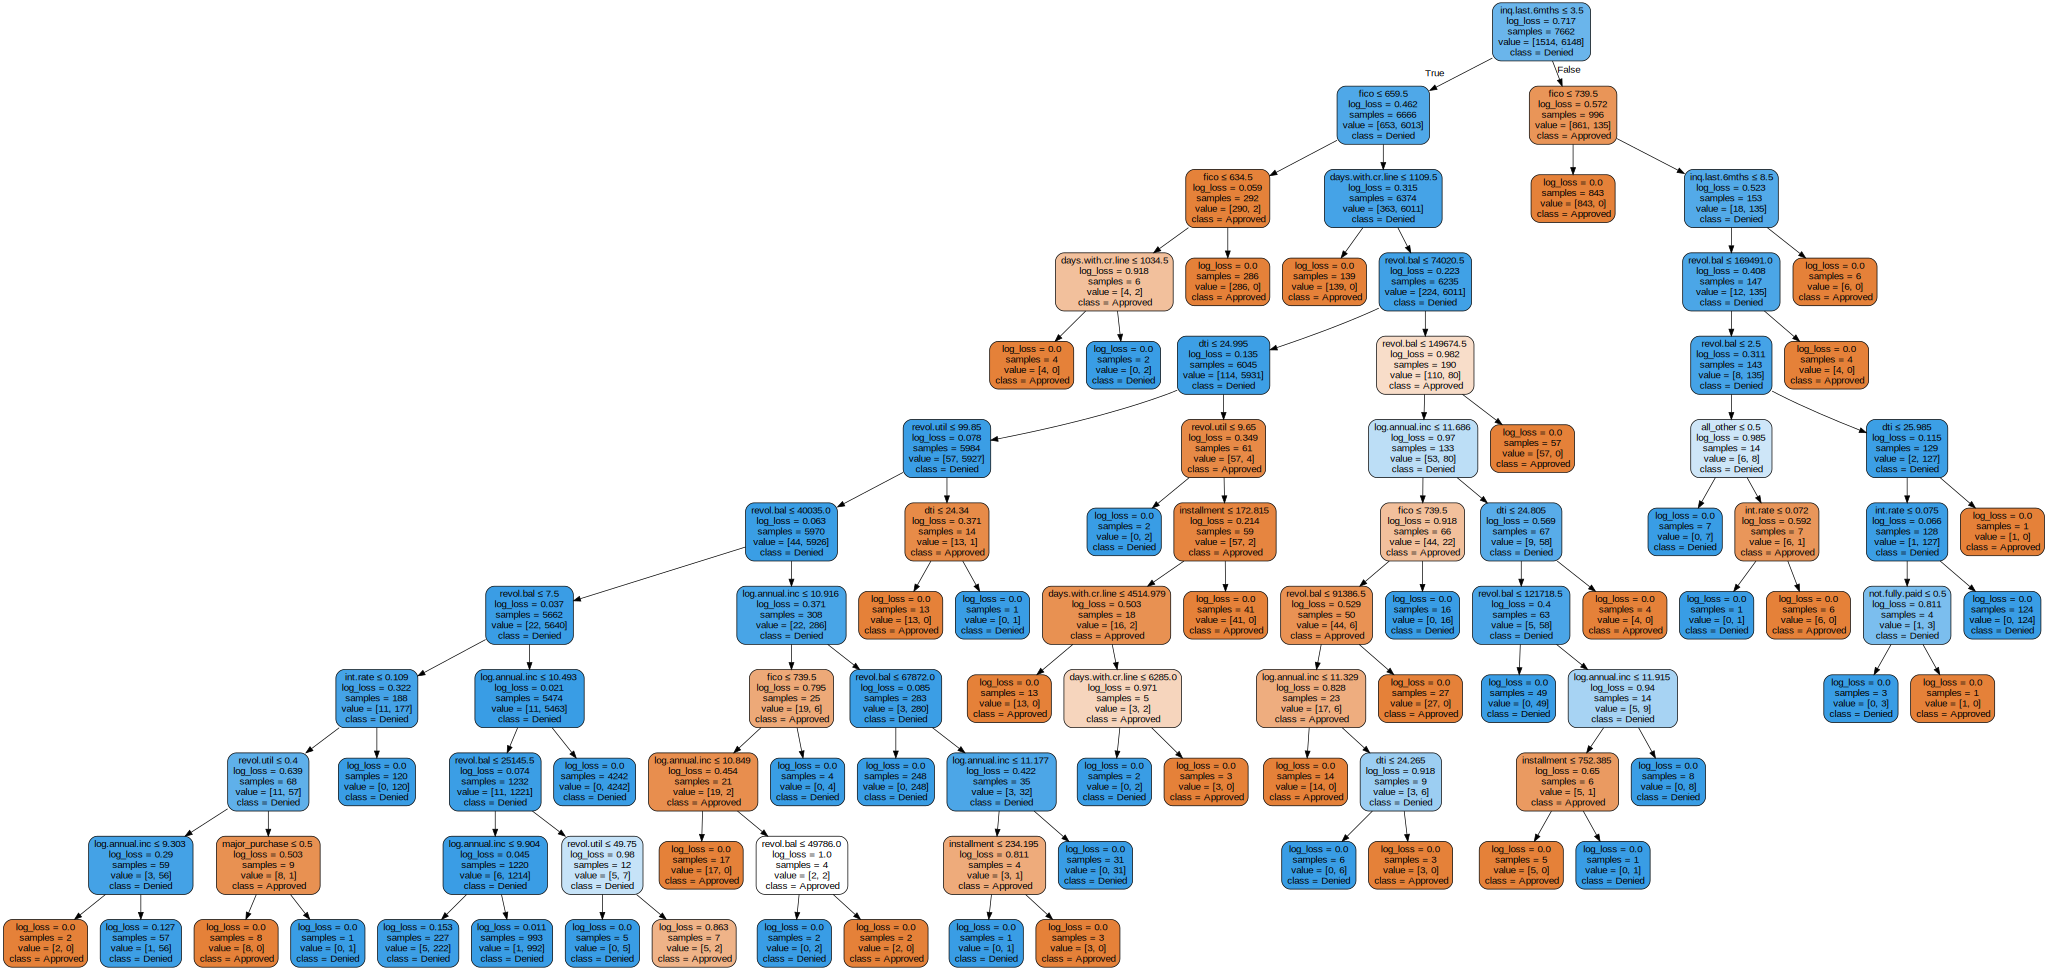

In [164]:
graph = plot_tree(best_dt)
graph

In [127]:
graph.render("Decision_Tree", format="png")

'Decision_Tree.png'

## Random Forest

In [128]:
# Parameters for GridSearch
param_grid = {'criterion':['gini', 'entropy', 'log_loss'],
              'n_estimators':list(range(100, 110, 2)),
              'max_depth':list(range(10, 18))
              }

grid_search_rf_clf = GridSearchCV(RandomForestClassifier(), param_grid=param_grid, cv=7, scoring="accuracy")
grid_search_rf_clf.fit(X_train, y_train)

# Print results of searching
means = grid_search_rf_clf.cv_results_['mean_test_score']
stds = grid_search_rf_clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, grid_search_rf_clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r"
        % (mean, std * 2, params))

0.987 (+/-0.007) for {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 100}
0.986 (+/-0.006) for {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 102}
0.987 (+/-0.006) for {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 104}
0.987 (+/-0.006) for {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 106}
0.986 (+/-0.007) for {'criterion': 'gini', 'max_depth': 10, 'n_estimators': 108}
0.987 (+/-0.006) for {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 100}
0.986 (+/-0.007) for {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 102}
0.987 (+/-0.005) for {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 104}
0.987 (+/-0.006) for {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 106}
0.987 (+/-0.006) for {'criterion': 'gini', 'max_depth': 11, 'n_estimators': 108}
0.987 (+/-0.006) for {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 100}
0.987 (+/-0.007) for {'criterion': 'gini', 'max_depth': 12, 'n_estimators': 102}
0.987 (+/-0.007) for {'crite

In [129]:
print("\nBest parameters on validation data:")
print(grid_search_rf_clf.best_params_)
y_pred = grid_search_rf_clf.predict(X_test)
print("\nAccuracy on test data:", accuracy_score(y_test, y_pred))


Best parameters on validation data:
{'criterion': 'entropy', 'max_depth': 16, 'n_estimators': 104}

Accuracy on test data: 0.9921711899791231


In [130]:
# Build model with best parameters
parameters = grid_search_rf_clf.best_params_
best_rf = RandomForestClassifier(criterion = parameters['criterion'],
                                 max_depth = parameters['max_depth'],
                                 n_estimators = parameters['n_estimators'])
best_rf.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=16, n_estimators=104)

In [131]:
y_pred = best_rf.predict(X_test)
print("Accuracy of best Random Forest:", accuracy_score(y_test, y_pred))

Accuracy of best Random Forest: 0.9916492693110647


In [137]:
print(classification_report(y_pred, y_test))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       346
           1       1.00      0.99      0.99      1570

    accuracy                           0.99      1916
   macro avg       0.98      0.99      0.99      1916
weighted avg       0.99      0.99      0.99      1916



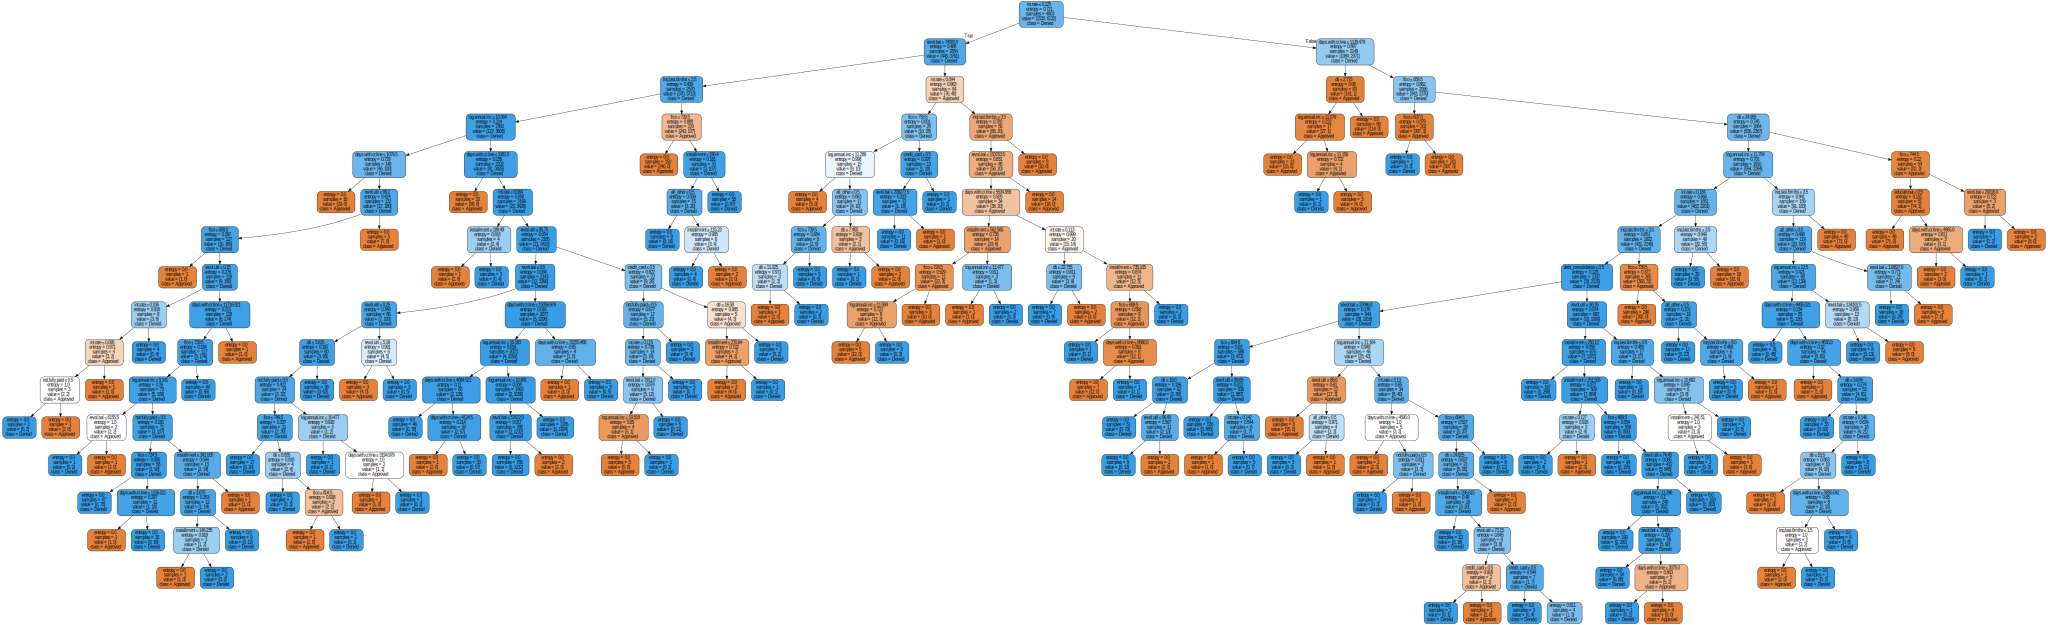

In [132]:
graph = plot_tree(best_rf.estimators_[0])
graph

In [133]:
graph.render("Random_Forest", format="png")

'Random_Forest.png'

## Model comparison

In [147]:
def print_metrics(y_actual, y_pred):
    """
    Evaluate the performance of a model while printing MAE, MSE, RMSE and R2 metrics

    :param y_actual: Actual targets from the test set
    :param y_pred: Values predicted by the model
    """
    print("Mean Absolute Error: ", metrics.mean_absolute_error(y_actual, y_pred))
    print("Mean Squared Error: ", metrics.mean_squared_error(y_actual, y_pred))
    print("Root Mean Squared Error: ", math.sqrt(metrics.mean_squared_error(y_actual, y_pred)))
    print("R2 score: ", metrics.r2_score(y_actual, y_pred))
    
def print_clf_metrics(y_actual, y_pred):
    """
    Evaluate the performance of a model while printing 
    Accuracy, Precision, Recall and F1 scores

    :param y_actual: Actual target from the test set
    :param y_pred: Value predicted by the model
    """
    
    print(f'Testing accuracy = {metrics.accuracy_score(y_actual, y_pred)}')
    print(f'Testing precision = {metrics.precision_score(y_actual, y_pred)}')
    print(f'Testing recall = {metrics.recall_score(y_actual, y_pred)}')
    print(f'Testing F1-score = {metrics.f1_score(y_actual, y_pred)}')

In [165]:
print("Decision Tree metrics:")
print_clf_metrics(y_test, best_dt.predict(X_test))
print_metrics(y_test, best_dt.predict(X_test))

Decision Tree metrics:
Testing accuracy = 0.9906054279749478
Testing precision = 0.9955070603337612
Testing recall = 0.9929577464788732
Testing F1-score = 0.9942307692307693
Mean Absolute Error:  0.009394572025052192
Mean Squared Error:  0.009394572025052192
Root Mean Squared Error:  0.09692560046268577
R2 score:  0.9376288547928557


In [166]:
print("Random Forest metrics:")
print_clf_metrics(y_test, best_rf.predict(X_test))
print_metrics(y_test, best_rf.predict(X_test))

Random Forest metrics:
Testing accuracy = 0.9916492693110647
Testing precision = 0.9923566878980892
Testing recall = 0.9974391805377721
Testing F1-score = 0.9948914431673052
Mean Absolute Error:  0.008350730688935281
Mean Squared Error:  0.008350730688935281
Root Mean Squared Error:  0.09138233247699076
R2 score:  0.944558982038094


In [167]:
acc_rf = accuracy_score(y_test, best_rf.predict(X_test))
acc_dt = accuracy_score(y_test, best_dt.predict(X_test))
f1_rf = metrics.f1_score(y_test, best_rf.predict(X_test))
f1_dt = metrics.f1_score(y_test, best_dt.predict(X_test))

if acc_dt > acc_rf:
    print("Decision Tree has better performance than Random Forest")
    print("Best accuracy:", acc_dt)
    print("Best F1:", f1_dt)
elif acc_dt < acc_rf:
    print("Random Forest has better performance than Decision Tree")
    print("Best accuracy:", acc_rf)
    print("Best F1:", f1_rf)
else:
    print("Random Forest and Decision Tree are equally good")
    print("Best accuracy:", acc_rf)
    print("Best F1:", f1_rf)

Random Forest has better performance than Decision Tree
Best accuracy: 0.9916492693110647
Best F1: 0.9948914431673052


### Questions
1. How did the DT compare to the RF in performance? Why?
    - *Answer*: The random forest shows better performance than the decision tree (higher accuracy and F1 score). However, the speed of the random forest is lower. The reason is that random forest is an ensemble learning method that operates by constructing a multitude of decision trees at training time. As one of the ensemble learning methods, it has higher metrics, but lower speed.
2. After fine-tuning, how does the max depth in DT compare to RF? Why?
    - *Answer*: After the fine-tuning Random forests have a greater maximum depth than a single decision tree because by combining the predictions of multiple decision trees, the random forest is able to capture more complex relationships between the features and the target variable, which can require a greater depth to achieve optimal performance.
3. What is ensemble learning? What are its pros and cons?
    - *Answer*: Ensemble learning is a machine learning technique that uses several learning algorithms to obtain higher prediction scores than can be achieved by one of the component learning algorithms.
      * Advantages:
        1. More accurate results of predictions;
        2. More stable, robust and less noisy model;
      * Disadvantages:
        1. A more complex model that is difficult to interpret;
        2. High model building and computation time.
4. Briefly explain 2 types of boosting methods and 2 types of bagging methods.
Which of these categories does RF fall under?
    - *Answer*: 
      1. Boosting:
        * Adaboost (Adaptive Boosting):
          The goal of Adaboost is to combine several weak models to create one strong model. Errors in the models are corrected, and any observations that were misclassified are given a higher weight than other observations that were classified correctly.
        * Gradient Boosting:
          Gradient boosting sequentially adds models to the ensemble and observes sequence in correcting previous models to produce a more accurate model at the end of the procedure. This boosting aims to fit the new model based on the errors made by the previous predictor.
      2. Bagging:
        * Bootstrapping:
          This is a sampling method in which samples are obtained from the entire dataset using a substitution procedure. The substitution sampling method helps to make the selection procedure random. A basic learning algorithm is run on the samples to complete the procedure.
        * Aggregation:
          Aggregation in bagging is done to incorporate all possible outcomes of the prediction and randomize the outcome.

        Random forest is one example of bagging methods.
